In [1]:
from scipy.optimize import least_squares, minimize, LinearConstraint
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd

In [2]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def hankelise(self, x, order):
    hankel_matrix = np.zeros((order * self.num_features, x.shape[1] - order + 1))
    for i in range(order):
      hankel_matrix[i*self.num_features:(i+1)*self.num_features, :] = x[:, i:i+x.shape[1]-order+1]
      
    return hankel_matrix

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    objective_value = np.square(np.linalg.norm(G, 'fro')) + np.linalg.norm(G, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K = params[:X_len], params[X_len+G_len+S_len:]
    X, K = X.reshape(X_shape), K.reshape(K_shape)

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = self.hankelise(X1, self.ar_order), self.hankelise(X2, self.ar_order)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params, D):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (D - X - G - S).flatten()
    
  def fit(self, D, bounds=None):
    X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
      D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features*self.ar_order, self.num_features*self.ar_order))

    G_initial_guess[:, self.ar_order] = 0
    S_initial_guess[:, self.ar_order] = 0

    for i in range(self.ar_order-1):
      K_initial_guess[i*self.num_features:(i+1)*self.num_features, (i+1)*self.num_features:(i+2)*self.num_features] = np.eye(self.num_features)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    # TODO pass in bounds
    # lb = [None, -0.6, -0.6, None]
    # ub = [None, 0.9, 0.9, None]
    # bounds = LinearConstraint(np.eye(4), lb=lb, ub=ub, keep_feasible=True)

    constraints = (
      {'type': 'eq', 'fun': self.hankel_constraint},
      {'type': 'eq', 'fun': self.D_constraint, 'args': (D,)},
    )

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints)

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)[-self.num_features:]

    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    for i in range(timesteps):
      hankel_window = self.hankelise(current_window, self.ar_order)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [3]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 3, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data = toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T
toy_data = np.tile(toy_data, (num_features, 1))
for i in range(num_features):
  toy_data[i, :] += i
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


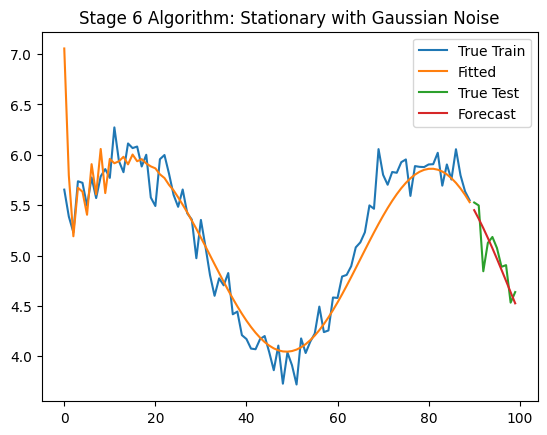

RMSE:  0.531103701647531


In [43]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 1, 10, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data = toy_datasets.periodical_sinusoidal_with_both_noise().reshape(-1, 1).T
toy_data = np.tile(toy_data, (num_features, 1))
for i in range(num_features):
  toy_data[i, :] += i
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

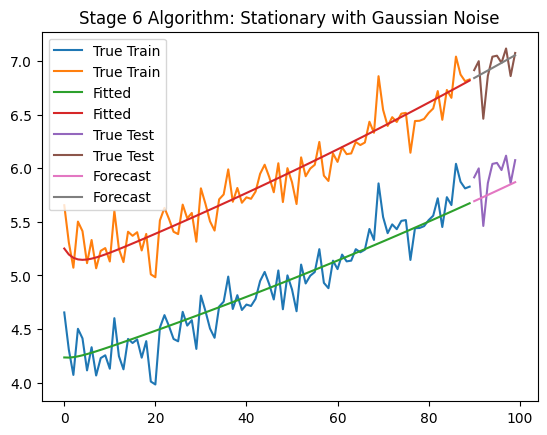

RMSE:  0.6243526619955018


In [15]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 2, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data = toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T
toy_data = np.tile(toy_data, (num_features, 1))
for i in range(num_features):
  toy_data[i, :] += i
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [25]:
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data = toy_datasets.linear_trending_with_both_noise().reshape(-1, 1).T
toy_data = np.tile(toy_data, (num_features, 1))
for i in range(num_features):
  toy_data[i, :] += i
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

KeyboardInterrupt: 